## Exploration 10. Create CIFAR-10 Image 📸

* Improving the GAN training process by modifying parameters
* LeakyReLU : alpha=0.2
* Adam : learning_rate=0.0002, beta_1=0.5
* Generator : ReLU → SeLU

https://flonelin.wordpress.com/2020/05/20/%EC%95%88%EC%A0%95%EC%A0%81%EC%9D%B8-generative-adversarial-network-%ED%8A%B8%EB%A0%88%EC%9D%B4%EB%8B%9D%EC%9D%84-%EC%9C%84%ED%95%9C-%ED%8C%81%EB%93%A4/

https://kdeon.tistory.com/60?category=941837

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.makedirs(os.getenv('HOME')+"/aiffel/dcgan_newimage/cat_parameter/training_history", exist_ok=True)
os.makedirs(os.getenv('HOME')+"/aiffel/dcgan_newimage/cat_parameter/generated_samples", exist_ok=True)
os.makedirs(os.getenv('HOME')+"/aiffel/dcgan_newimage/cat_parameter/training_checkpoints", exist_ok=True)

In [3]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [4]:
train_x, test_x = load_data(3)
train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(5000, 32, 32, 3)

In [5]:
test_x.shape

(1000, 32, 32, 3)

In [6]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [7]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [8]:
train_x.shape

(5000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


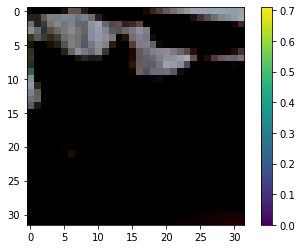

In [9]:
# 첫 번째 이미지 꺼내서 확인해보기(시각화)

plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

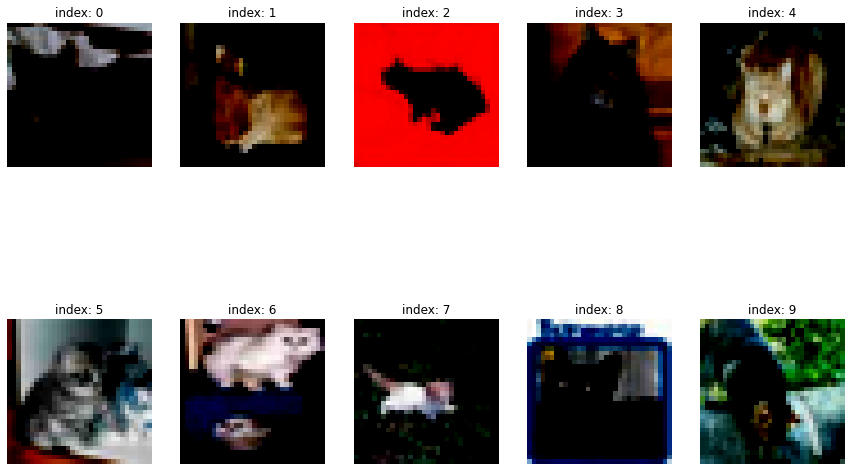

In [10]:
# 이미지 열 개 정도 한 번에 띄워보기

plt.figure(figsize=(15, 10))  # 이미지의 전체 프레임의 크기 결정

for i in range(10):
    plt.subplot(2, 5, i+1)  # 여러 개의 이미지를 한 번에 띄우기(10개의 이미지, 2x5의 배열 형태)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')  # 이미지에 제목으로 라벨 값
    plt.axis('off')  # 불필요한 축 지우기
plt.show()

In [11]:
BUFFER_SIZE = 50000  # 전체 데이터를 섞기 위해 50,000으로 설정
BATCH_SIZE = 128  # 모델이 한 번에 학습할 데이터의 양

In [12]:
# 정리된 데이터를 곧 모델에 넣어서 학습시켜야 하니, 편하게 사용할 수 있도록 텐서플로우의 Dataset을 이용해 준비
# shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어준다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
# make_generator_model이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록 한다.
def make_generator_model():

    # Start
    # tf.keras.Sequential()로 모델을 시작한 후 레이어를 쌓는다.
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,), activation='selu'))
    model.add(layers.BatchNormalization())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    # Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False, activation='selu'))
    model.add(layers.BatchNormalization())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False, activation='selu'))
    model.add(layers.BatchNormalization())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [14]:
# generator라는 변수로 생성하고, 모델 세부 내용인 summary 출력
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        204800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        2

In [15]:
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들어 본다.
# 아직 모델이 학습되지 않았으므로 결과물도 큰 의미가 있지는 않을 것
# tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다.

noise = tf.random.normal([1, 100])

In [16]:
# 지금은 학습하는 중이 아니므로 training=False
# Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 
# training=False을 주어야 올바른 결과를 얻을 수 있다.

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

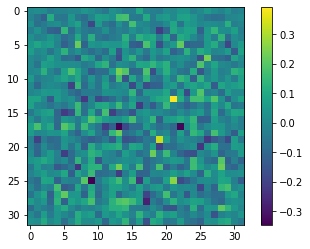

In [17]:
# 생성된 이미지 시각화
# matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있다.
# 0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 꺼낼 수 있도록 한다.

plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [18]:
# 판별자 또한 make_discriminator_model 함수로 구현
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [19]:
# 판별 모델을 discriminator라는 변수 이름으로 생성
# 모델 세부 내용인 summary를 출력

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [20]:
# 판별자에 위에서 생성했던 가짜 이미지를 입력

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5027992]], dtype=float32)>

In [21]:
# 손실함수에 사용할 교차 엔트로피 함수는 tf.keras.losses 라이브러리 안에 있다. 

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [24]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [26]:
# 샘플은 한 번에 16장을 생성
# 생성할 샘플은 매번 같은 노이즈로 생성해야 진전 과정을 확인할 수 있으므로, 
# 고정된 seed 노이즈를 만들어두어야 한다.
# 즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 한다.

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [27]:
import numpy as np
import tensorflow as tf

@tf.function
def f(x, y):
    print(type(x))
    print(type(y))
    return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [28]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [29]:
# 한 단계씩 학습할 train_step과 함께 
# 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수
# 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인 가능
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    np_predictions = predictions.numpy()
    np_predictions = (np_predictions * 127.5) + 127.5 # 정규화 했던 것을 되돌리기
    np_predictions = np_predictions.astype(int)   
        
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np_predictions[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cat_parameter/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [30]:
# train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 
# 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가
# 매 epoch마다 시각화하는 함수

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cat_parameter/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [31]:
# 정기적으로 모델을 저장하기 위한 checkpoint

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cat_parameter/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [32]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [33]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

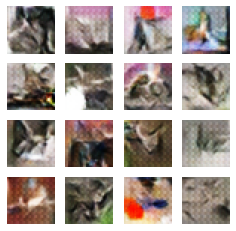

Time for training : 1634 sec


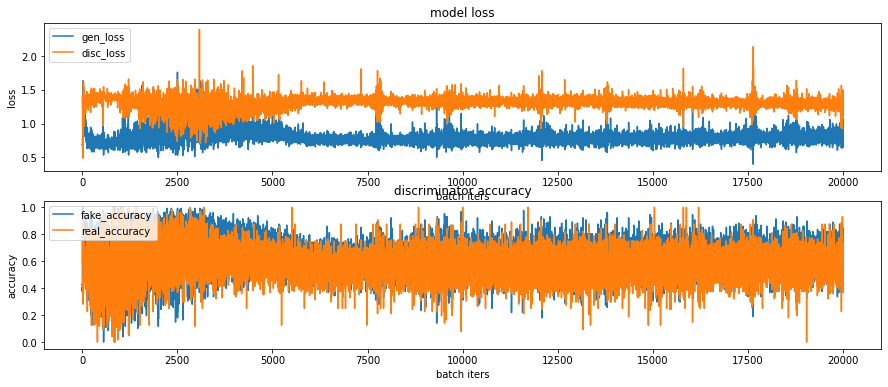

CPU times: user 29min 34s, sys: 4min 31s, total: 34min 6s
Wall time: 27min 16s


In [34]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 
# ~/aiffel/dcgan_newimage/fashion2/training_history 경로에 생성
# 진행 과정을 수시로 확인해 보기

In [2]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cat_parameter/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cat_parameter/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cat_parameter/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1690253 Feb 15 09:03 /aiffel/aiffel/dcgan_newimage/cat_parameter/cifar10_dcgan.gif


In [3]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cat_parameter/graph_cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cat_parameter/training_history/train_history*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cat_parameter/graph_cifar10_dcgan.gif

-rw-r--r-- 1 root root 4111000 Feb 15 09:03 /aiffel/aiffel/dcgan_newimage/cat_parameter/graph_cifar10_dcgan.gif
